In [1]:
!pip install Arabic-Stopwords
!pip install arabic_reshaper
!pip install python-bidi

     |████████████████████████████████| 353 kB 5.2 MB/s 
     |████████████████████████████████| 126 kB 34.8 MB/s 


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import string
import arabicstopwords.arabicstopwords as ar_words
import os
import codecs
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
import collections

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#read files of first dataset (MSA)
res_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/RES.csv')
prod_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/PROD.csv')
htl_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/HTL.csv')
mov_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/MOV.csv')

In [4]:
#keep only binary classes (pos & neg)
res_df=res_df[res_df['polarity']!=0].reset_index(drop=True)
prod_df=prod_df[prod_df['polarity']!=0].reset_index(drop=True)
htl_df=htl_df[htl_df['polarity']!=0].reset_index(drop=True)
mov_df=mov_df[mov_df['polarity']!=0].reset_index(drop=True)

In [5]:
res_df.head()

,text,polarity
0,٦٠ \nاللي يوصل ميلان ولا يمر هالمطعم اعتبرة خس...,1
1,رااااائع \nالمطعم أكله لذيذ جداً والعاملين متع...,1
2,جيد \nمطعم جيد\nالعاملين فيه ودون\nبالنسبة للأ...,1
3,مطعم جميل جدااااا \nمأكولات بجد جميله جداااااا...,1
4,مطعم مصري.. \nالسلام عليكم.. المطعم ممتاز جداً...,1


In [6]:
datasetDict = {"resturants": res_df, "products": prod_df, "hotels": htl_df, "movies": mov_df}

In [7]:
#check for null values
for k, v in datasetDict.items():
    print(k,'\n',v.isnull().sum())

resturants 
 text        0
polarity    0
dtype: int64
products 
 text        0
polarity    0
dtype: int64
hotels 
 text        0
polarity    0
dtype: int64
movies 
 text        0
polarity    0
dtype: int64


In [8]:
#dataset sizes
print('-DATASET-','-SIZE-')
total=0
for k, v in datasetDict.items():
    print(k, len(v))
    #print(v.polarity.value_counts(normalize=True))
    total+= len(v)
print('TOTAL',total)

-DATASET- -SIZE-
resturants 10705
products 3964
hotels 13422
movies 1353
TOTAL 29444


In [ ]:
# msa_combined_df = pd.concat([res_df,prod_df,htl_df,mov_df])
# print(len(msa_combined_df))
# print(msa_combined_df.polarity.value_counts(normalize=True))

29444
 1    0.776899
-1    0.223101
Name: polarity, dtype: float64


In [ ]:
# msa_text_list = msa_combined_df['text'].values # extract text column as list
# msa_words_list = [text.split() for text in msa_text_list] # split each tweet into the corresponding words
# msa_words = [word for text_words in msa_words_list for word in text_words] # merge words into one list
# print('Total number of words: ', len(msa_words))
# print('Total number of unique words: ', len(set(msa_words)))

Total number of words:  2218600
Total number of unique words:  234110


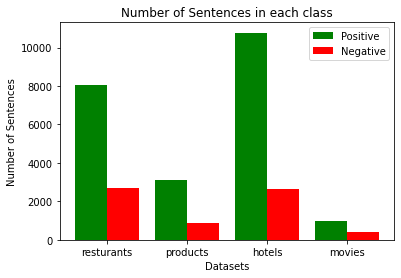

In [9]:
pos = []
neg = []
X = []
for k, v in datasetDict.items():
    pos.append(len(datasetDict[k][datasetDict[k]['polarity']==1]))
    neg.append(len(datasetDict[k][datasetDict[k]['polarity']==-1]))
    X.append(k)

    X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, pos, 0.4, label = 'Positive', color='green')
plt.bar(X_axis + 0.2, neg, 0.4, label = 'Negative', color='red')
  
plt.xticks(X_axis, X)
plt.xlabel("Datasets")
plt.ylabel("Number of Sentences")
plt.title("Number of Sentences in each class")
plt.legend()
plt.show()

In [10]:
#customized stopwords
ar_sw=['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'إنها', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما','كان','كانت', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير', 'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها', 'قد', 'كأن', 'كأنما', 'كأي', 'كأين', 'كذا', 'كذلك', 'كل', 'كلا', 'كلاهما', 'كلتا', 'كلما', 'كليكما', 'كليهما', 'كم', 'كم', 'كما', 'كي', 'كيت', 'كيف', 'كيفما', 'لا', 'لاسيما', 'لدى', 'لست', 'لستم', 'لستما', 'لستن', 'لسن', 'لسنا', 'لعل', 'لك', 'لكم', 'لكما', 'لكن', 'لكنما', 'لكي', 'لكيلا', 'لم', 'لما', 'لن', 'لنا', 'له', 'لها', 'لهم', 'لهما', 'لهن', 'لو', 'لولا', 'لوما', 'لي', 'لئن', 'ليت', 'ليس', 'ليسا', 'ليست', 'ليستا', 'ليسوا', 'ما', 'ماذا', 'متى', 'مذ', 'مع', 'مما', 'ممن', 'من', 'منه', 'منها', 'منذ', 'مه', 'مهما', 'نحن', 'نحو', 'نعم', 'ها', 'هاتان', 'هاته', 'هاتي', 'هاتين', 'هاك', 'هاهنا', 'هذا', 'هذان', 'هذه', 'هذي', 'هذين', 'هكذا', 'هل', 'هلا', 'هم', 'هما', 'هن', 'هنا', 'هناك', 'هنالك', 'هو', 'هؤلاء', 'هي', 'هيا', 'هيت', 'هيهات', 'والذي', 'والذين', 'وإذ', 'وإذا', 'وإن', 'ولا', 'ولكن', 'ولو', 'وما', 'ومن', 'وهو', 'يا']

def normalizeArabic(t):
    t = re.sub("[إأٱآا]", "ا", t)
    t = re.sub("ى", "ي", t)
    t = re.sub("ة", 'ه', t)
    t = re.sub("ؤ", "ء", t)
    t = re.sub("ئ", "ء", t)
    return (t)

ar_stop= []
for w in ar_sw:
  ar_stop.append(normalizeArabic(w))

In [11]:
#COLLECT extra Ar stopwords from 2 sources
ar_stopwords = stopwords.words('arabic') + list(ar_words.stopwords_list()) + ar_stop
print('nlkt arabic stopwords =',len(stopwords.words('arabic')))
print('Arabic-Stopwords =', len(ar_words.stopwords_list()))
print('My list =', len(ar_stop))
print('sum =',len(ar_stopwords), ', unique=', len(set(ar_stopwords)) )

nlkt arabic stopwords = 754
Arabic-Stopwords = 13629
My list = 251
sum = 14634 , unique= 13997


In [12]:
# define function to clean the text and remove unwanted text parts
def clean_text(text):
    # define regular expression patterns
    p_english = "[a-zA-Z0-9]+"
    p_url = "https?://[A-Za-z0-9./]+"
    p_mention = "\@[\_0-9a-zA-Z]+\:?"    
    p_retweet = "RT \@[\_\-0-9a-zA-Z]+\:?"
    p_punctuations = "[" + string.punctuation + "]"
    
    # remove unwanted parts
    text = re.sub(p_english, ' ', text)
    text = re.sub(p_retweet, ' ', text)
    text = re.sub(p_mention, ' ', text)
    text = re.sub(p_url, ' ', text)
    text = re.sub(p_punctuations, ' ', text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # remove الهمزة
    text = re.sub("[أإآ]", 'ا', text)
    text = re.sub("ة", 'ه', text)
    text = re.sub("ى", 'ي', text)
    
    # removing tashkeel
    tashkel = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(tashkel, '', text)
    
    # remove repeated letters more than two letters
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    
    # remove stopwords
    words = [word for word in text.split() if word not in ar_stopwords]
    words = [word for word in words if len(word)>=2]
    
    # merge and return final text
    return ' '.join(words)

In [13]:
# apply clean function on all text in datasets
for k, v in datasetDict.items():
    v['clean_text'] = v['text'].apply(clean_text)

In [14]:
#combine all domains in one frame to check stat. about data
msa_combined_df = pd.concat([res_df,prod_df,htl_df,mov_df])
print("Total number of doc in all domains: ",len(msa_combined_df))

# before cleaning
msa_text_list = msa_combined_df['text'].values # extract text column as list
msa_words_list = [text.split() for text in msa_text_list] # split each doc into the corresponding words
msa_words = [word for text_words in msa_words_list for word in text_words] # merge words into one list
print('---Before cleaning---')
print('Total number of words: ', len(msa_words))
print('Total number of unique words: ', len(set(msa_words)))

# after cleaning
msa_clean_text_list = msa_combined_df['clean_text'].values # extract text column as list
msa_clean_words_list = [text.split() for text in msa_clean_text_list] # split each tweet into the corresponding words
msa_clean_words = [word for text_words in msa_clean_words_list for word in text_words] # merge words into one list

print('---After cleaning---')
print('Total number of words: ', len(msa_clean_words))
print('Total number of unique words: ', len(set(msa_clean_words)))

print('---Number of deleted words---')
print('Total number of deleted word:',len(msa_words)-len(msa_clean_words))
print('Total number of unique deleted word:',len(set(msa_words))-len(set(msa_clean_words)))


Total number of doc in all domains:  29444
---Before cleaning---
Total number of words:  2218600
Total number of unique words:  234110
---After cleaning---
Total number of words:  1523143
Total number of unique words:  147781
---Number of deleted words---
Total number of deleted word: 695457
Total number of unique deleted word: 86329


Number of documents with words less than  5  in  resturants  dataset =  889


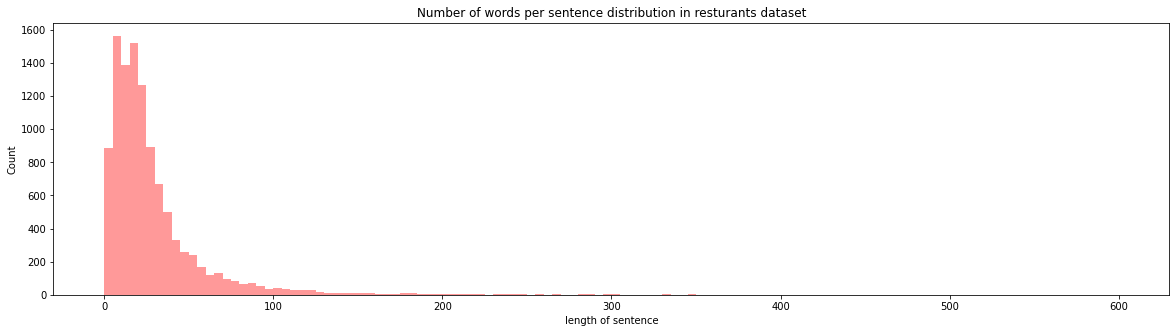

Number of documents with words less than  5  in  products  dataset =  1527


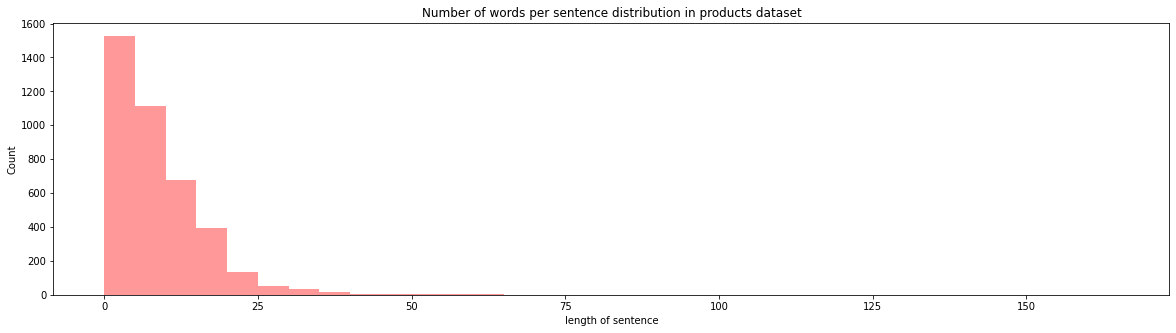

Number of documents with words less than  5  in  hotels  dataset =  14


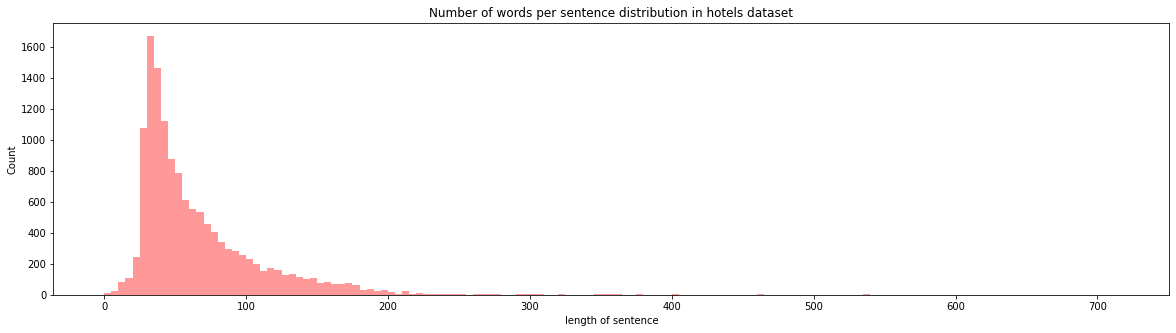

Number of documents with words less than  5  in  movies  dataset =  1


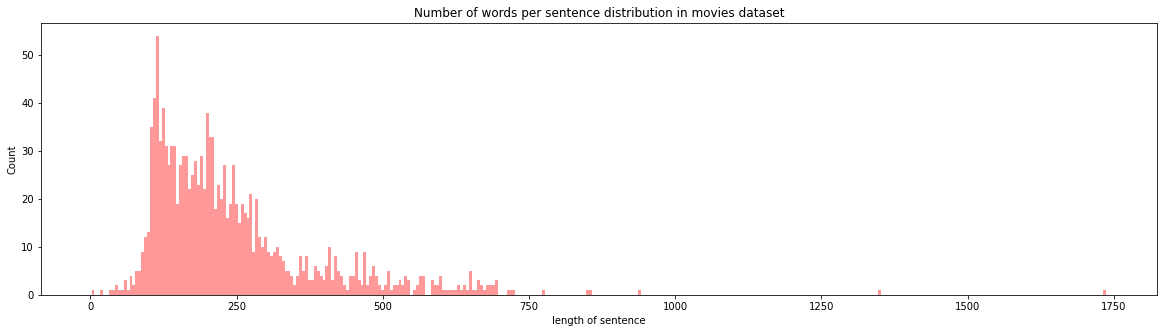

Number of documents with words less than  5  in all dataset =  2431


In [15]:
#words distributions, and # of doc with words less than 5
min_words= 5
total_short=0
for k, v in datasetDict.items():
    sentences_len = [len(i.split()) for i in v['clean_text'] if i!=0]
    print('Number of documents with words less than ',min_words, ' in ',k, ' dataset = ',sum(1 for i in sentences_len if i < min_words))
    total_short+=sum(1 for i in sentences_len if i < min_words)
    plt.figure(figsize=(20,5))
    plt.hist( sentences_len, bins=range(min( sentences_len), max( sentences_len) + 5, 5), 
              alpha=0.4, color="red")
    plt.xlabel("length of sentence")
    plt.ylabel("Count")
    plt.title("Number of words per sentence distribution in "+ k + ' dataset')
    plt.show()
print('Number of documents with words less than ',min_words, ' in all dataset = ',total_short)

In [ ]:
#How to keep only doc with 5 words or more (change df to the df name)
#df[df['clean_text'].apply(len)>=min_words]

# to be used later in training

In [16]:
# reshape arabic text for vis
from bidi.algorithm import get_display
import arabic_reshaper
def reshape_text(text):
    rtext = arabic_reshaper.reshape(text)
    return get_display(rtext)

Total number of words:  300831
Total number of unique words:  46499


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


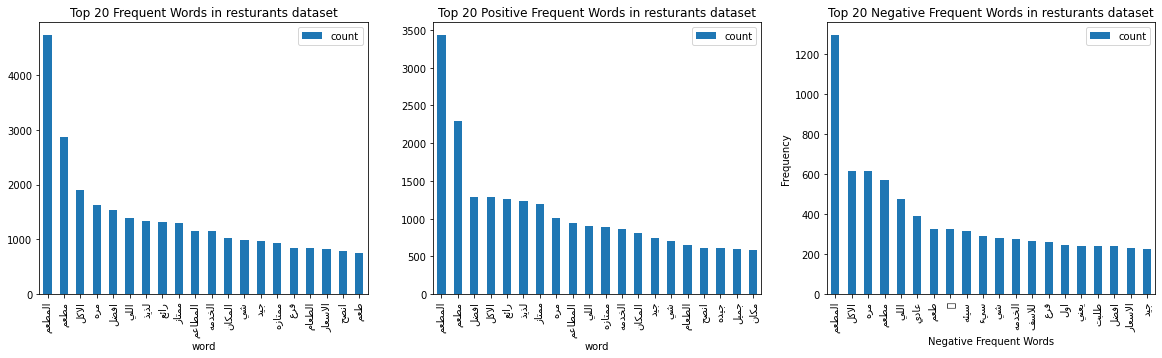

Total number of words:  32809
Total number of unique words:  9910


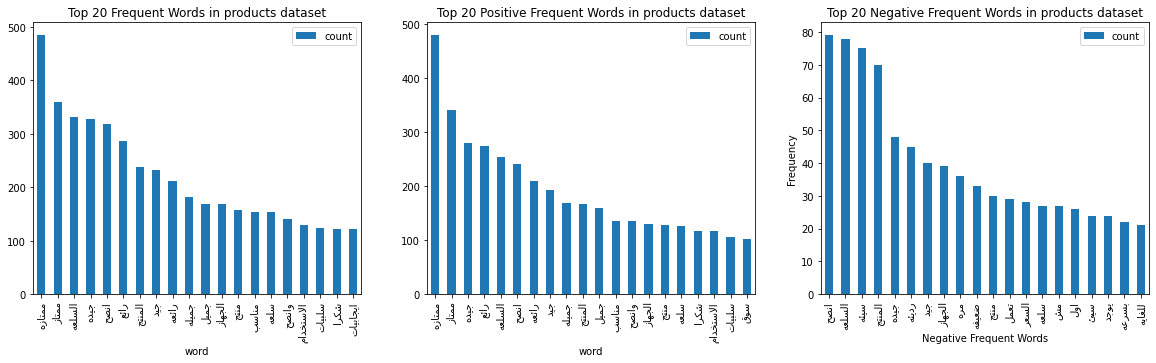

Total number of words:  864782
Total number of unique words:  85493


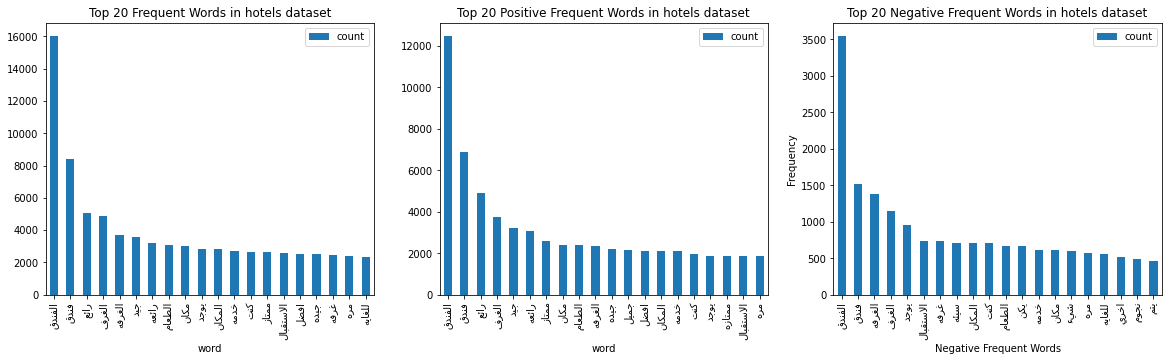

Total number of words:  324721
Total number of unique words:  62511


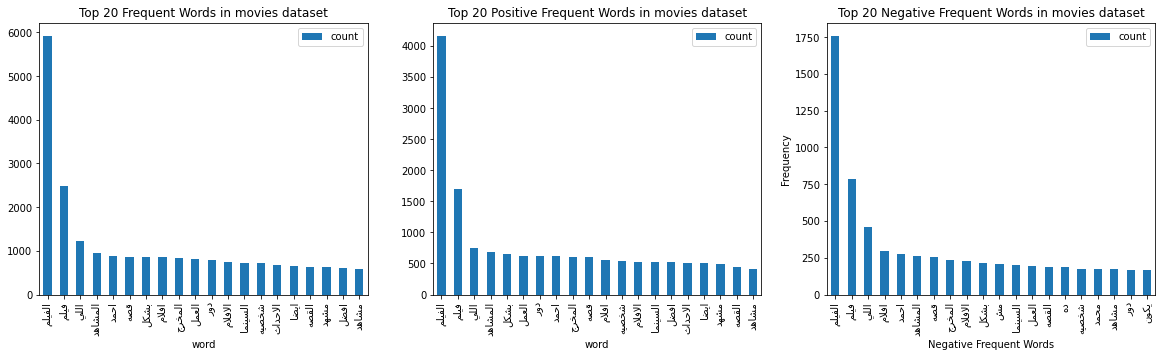

In [17]:
import collections

for k, v in datasetDict.items():
    all_text_list = v['clean_text'].values # extract text column as list
    all_words_list = [text.split() for text in all_text_list] # split each tweet into the corresponding words
    all_words = [word for text_words in all_words_list for word in text_words] # merge words into one list
    print('Total number of words: ', len(all_words))
    print('Total number of unique words: ', len(set(all_words)))
    # count the occurences/frequency of each word
    all_words_count = collections.Counter(all_words)
    # plot high frequency words (top 20 words)
    # get top 20 words (most common)
    all_frequent_words = pd.DataFrame(all_words_count.most_common(20),columns=['word', 'count']) 
    all_frequent_words['word']= all_frequent_words['word'].apply(reshape_text)

    #same for pos text only
    pos_text_list = v[v['polarity']==1].clean_text.values
    pos_words_list = [text.split() for text in pos_text_list]
    pos_words = [word for text_words in pos_words_list for word in text_words]
    pos_words_count = collections.Counter(pos_words)
    pos_frequent_words = pd.DataFrame(pos_words_count.most_common(20),columns=['word', 'count']) 
    pos_frequent_words['word']= pos_frequent_words['word'].apply(reshape_text)

    #same for neg text only
    neg_text_list = v[v['polarity']==-1].clean_text.values
    neg_words_list = [text.split() for text in neg_text_list]
    neg_words = [word for text_words in neg_words_list for word in text_words]
    neg_words_count = collections.Counter(neg_words)
    neg_frequent_words = pd.DataFrame(neg_words_count.most_common(20),columns=['word', 'count']) 
    neg_frequent_words['word']= neg_frequent_words['word'].apply(reshape_text)

    # plot the frequency chart as bar chart
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
    all_frequent_words.plot(kind='bar', x='word', y='count',  ax=ax1)
    #ax1.bar('word', 'count', data=all_frequent_words)
    plt.xlabel('Frequent Words')
    plt.ylabel('Frequency')
    ax1.set_title('Top 20 Frequent Words in ' + k +' dataset')
    #plt.title('Top 20 Frequent Words in ' + k +' dataset')
    
    pos_frequent_words.plot(kind='bar', x='word', y='count',  ax=ax2)
    #ax2.bar('word','count', data=pos_frequent_words)
    plt.xlabel('Positive Frequent Words')
    plt.ylabel('Frequency')
    ax2.set_title('Top 20 Positive Frequent Words in ' + k +' dataset')
    #plt.title('Top 20 Positive Frequent Words in ' + k +' dataset')

    neg_frequent_words.plot(kind='bar', x='word', y='count',  ax=ax3)
    #ax3.bar('word','count', data=neg_frequent_words)
    plt.xlabel('Negative Frequent Words')
    plt.ylabel('Frequency')
    ax3.set_title('Top 20 Negative Frequent Words in ' + k +' dataset')
    #plt.title('Top 20 Negative Frequent Words in ' + k +' dataset')

    plt.show()

In [18]:
!wget 'https://github.com/frappe/fonts/raw/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf'

--2021-12-12 14:52:29--  https://github.com/frappe/fonts/raw/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/frappe/fonts/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf [following]
--2021-12-12 14:52:29--  https://raw.githubusercontent.com/frappe/fonts/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134028 (131K) [application/octet-stream]
Saving to: ‘NotoNaskhArabic-Regular.ttf’

NotoNaskhArabic-Reg 100%[===================>] 130.89K  --.-KB/s    in 0.01s   

2021-12-12 1

WordCloud of top 500 words in resturants dataset


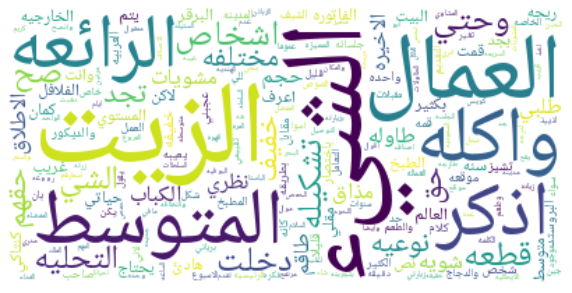

WordCloud of top 500 words in products dataset


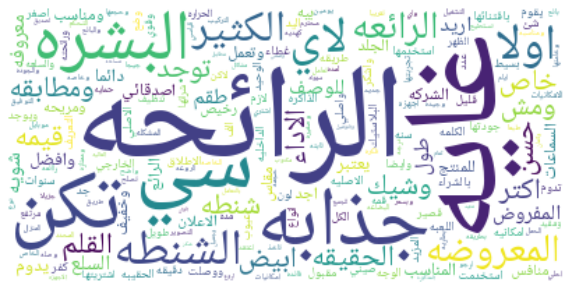

WordCloud of top 500 words in hotels dataset


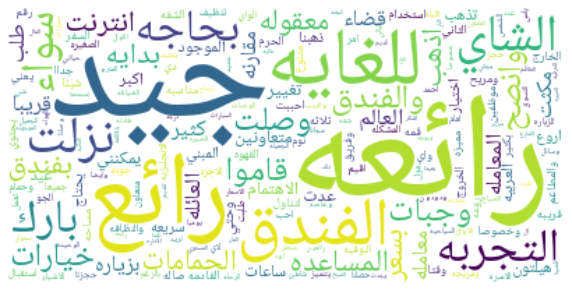

WordCloud of top 500 words in movies dataset


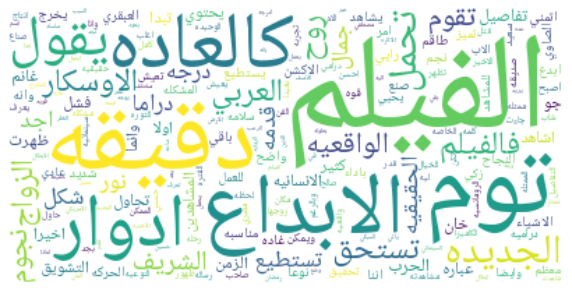

In [20]:
# Wordcoulds
for k, v in datasetDict.items():
        clean_text_list = v['clean_text'].values # extract text column as list
        words_list = [text.split() for text in clean_text_list] # split each tweet into the corresponding words
        all_words = [word for text_words in words_list for word in text_words] # merge words into one list
        words_count = collections.Counter(all_words) # count the occurences/frequency of each word
        # get top n words (most common)
        top_n = 500
        top_n_words_df = pd.DataFrame(words_count.most_common(top_n),columns=['word', 'count'])
        # Make text readable for a non-Arabic library like wordcloud
        text = arabic_reshaper.reshape(" ".join(top_n_words_df['word']))
        text = get_display(text)
        # Generate a word cloud image
        plt.figure(figsize=(10,10))
        wordcloud = WordCloud(font_path='NotoNaskhArabic-Regular.ttf', background_color='white').generate(text)
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
        print('WordCloud of top ' + str(top_n) + ' words in '+ k + ' dataset')
        plt.show()
        # Export to an image
        #wordcloud.to_file("arabic_example.png")

In [21]:
!pip install tashaphyne

     |████████████████████████████████| 244 kB 8.9 MB/s 


In [ ]:
from textblob import TextBlob
from tashaphyne.stemming import ArabicLightStemmer
from nltk.stem.isri import ISRIStemmer

In [ ]:
# more pre-processing #Stemming
ArListem = ArabicLightStemmer()

def stem(text):
     zen = TextBlob(text)
     words = zen.split()
     Stemmed = list()
     for w in words:
         ArListem.light_stem(w)
         Stemmed.append(ArListem.get_stem())
     return " ".join(Stemmed)

In [ ]:
for k, v in datasetDict.items():
  v['stemmed_text'] = v['clean_text'].apply(stem)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_count1 = CountVectorizer()
vectorizer_count2 = CountVectorizer(ngram_range=(1,2))
vectorizer_Tfidf1 = TfidfVectorizer()
vectorizer_Tfidf2 = TfidfVectorizer(ngram_range=(1,2))

Vectorizers = {"count1": vectorizer_count1, "count2": vectorizer_count2, "Tfidf1": vectorizer_Tfidf1, "Tfidf2": vectorizer_Tfidf2}

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

clf_Lsvc = LinearSVC()
clf_svc = SVC()

Classifiers = {"LinearSvc": clf_Lsvc, "Svc": clf_svc}

In [ ]:
#get baseline resuts of cleaning with out stemming

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

for k, v in datasetDict.items():
  X = v['clean_text']
  encoder = LabelEncoder()
  y = encoder.fit_transform(v['polarity'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
  print("--------------------------------------------------------------------------- Dataset:",k )
  print('Training: ', x_train.shape)
  print('Testing: ', x_test.shape)

  for k1, v1 in Vectorizers.items():
    X_train = v1.fit_transform(x_train)
    features_count = len(v1.vocabulary_)
    print("-------------------------------------- Vecotizor: ", k1)
    print('Number of features: ', features_count)
    print('Shape of training X: ', X_train.shape)
    X_test = v1.transform(x_test)
    print('Shape of testing X: ', X_test.shape)

    for k2, v2 in Classifiers.items():
      v2.fit(X_train, y_train)
      # check the training and testing accuracies
      print("------------------- Classifier: ", k2)
      print('Training Accuracy: ', v2.score(X_train,y_train))
      print('Testing Accuracy: ', v2.score(X_test,y_test))
      predections = v2.predict(X_test)
      print('Testing F1 score: ', f1_score(y_test, predections))
      print('Testing precision score: ', precision_score(y_test, predections))
      print('Testing recall score: ', recall_score(y_test, predections))
    
    if k1 == "count1":
      MAX_WORDS = int(len(v1.vocabulary_) * 0.5)
      vectorizer_countMax = CountVectorizer(max_features=MAX_WORDS)
      X_train = vectorizer_countMax.fit_transform(x_train)
      print("-------------------------------------- Vecotizor: ", k1, " Max ", MAX_WORDS, " features." )
      print('Number of features: ', features_count * 0.5)
      print('Shape of training X: ', X_train.shape)
      X_test = vectorizer_countMax.transform(x_test)
      print('Shape of testing X: ', X_test.shape)
      for kk, vv in Classifiers.items():
        vv.fit(X_train, y_train)
        # check the training and testing accuracies
        print("------------------- Classifier: ", kk)
        print('Training Accuracy: ', vv.score(X_train,y_train))
        print('Testing Accuracy: ', vv.score(X_test,y_test))
        predections = vv.predict(X_test)
        print('Testing F1 score: ', f1_score(y_test, predections))
        print('Testing precision score: ', precision_score(y_test, predections))
        print('Testing recall score: ', recall_score(y_test, predections))

--------------------------------------------------------- Dataset: resturants
Training:  (8564,)
Testing:  (2141,)
-------------------------------------- Vecotizor:  count1
Number of features:  39332
Shape of training X:  (8564, 39332)
Shape of testing X:  (2141, 39332)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  count1
Training Accuracy:  0.9970808033629145
Testing Accuracy:  0.85007006071929
Testing F1 score:  0.9020445529447665
Testing precision score:  0.8845002992220228
Testing recall score:  0.9202988792029888
------------------- Classifier:  count1
Training Accuracy:  0.9388136384866884
Testing Accuracy:  0.8313872022419431
Testing F1 score:  0.896886603827478
Testing precision score:  0.8284960422163589
Testing recall score:  0.9775840597758406
-------------------------------------- Vecotizor:  count2
Number of features:  227563
Shape of training X:  (8564, 227563)
Shape of testing X:  (2141, 227563)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  count2
Training Accuracy:  0.9981317141522653
Testing Accuracy:  0.8496029892573563
Testing F1 score:  0.902542372881356
Testing precision score:  0.8780918727915195
Testing recall score:  0.9283935242839353
------------------- Classifier:  count2
Training Accuracy:  0.9414992993928071
Testing Accuracy:  0.8346567024754787
Testing F1 score:  0.8986834573554665
Testing precision score:  0.8315677966101694
Testing recall score:  0.9775840597758406
-------------------------------------- Vecotizor:  Tfidf1
Number of features:  39332
Shape of training X:  (8564, 39332)
Shape of testing X:  (2141, 39332)
------------------- Classifier:  Tfidf1
Training Accuracy:  0.9934609995329285
Testing Accuracy:  0.8738907052779075
Testing F1 score:  0.9190647482014388
Testing precision score:  0.8861271676300578
Testing recall score:  0.9545454545454546
------------------- Classifier:  Tfidf1
Training Accuracy:  0.9889070527790752
Testing Accuracy:  0.8542737038766931
Te

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  count2
Training Accuracy:  1.0
Testing Accuracy:  0.8376383763837638
Testing F1 score:  0.8962264150943396
Testing precision score:  0.8260869565217391
Testing recall score:  0.979381443298969
------------------- Classifier:  count2
Training Accuracy:  0.9251386321626618
Testing Accuracy:  0.7195571955719557
Testing F1 score:  0.8362068965517242
Testing precision score:  0.7185185185185186
Testing recall score:  1.0
-------------------------------------- Vecotizor:  Tfidf1
Number of features:  50970
Shape of training X:  (1082, 50970)
Shape of testing X:  (271, 50970)
------------------- Classifier:  Tfidf1
Training Accuracy:  1.0
Testing Accuracy:  0.8265682656826568
Testing F1 score:  0.8899297423887588
Testing precision score:  0.8154506437768241
Testing recall score:  0.979381443298969
------------------- Classifier:  Tfidf1
Training Accuracy:  1.0
Testing Accuracy:  0.7195571955719557
Testing F1 score:  0.8362068965517242
Testing precision score:  

In [ ]:
#get baseline resuts of cleaning and stemming

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

for k, v in datasetDict.items():
  X = v['stemmed_text']
  encoder = LabelEncoder()
  y = encoder.fit_transform(v['polarity'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
  print("--------------------------------------------------------------------------- Dataset:",k )
  print('Training: ', x_train.shape)
  print('Testing: ', x_test.shape)

  for k1, v1 in Vectorizers.items():
    X_train = v1.fit_transform(x_train)
    features_count = len(v1.vocabulary_)
    print("-------------------------------------- Vecotizor: ", k1)
    print('Number of features: ', features_count)
    print('Shape of training X: ', X_train.shape)
    X_test = v1.transform(x_test)
    print('Shape of testing X: ', X_test.shape)

    for k2, v2 in Classifiers.items():
      v2.fit(X_train, y_train)
      # check the training and testing accuracies
      print("------------------- Classifier: ", k2)
      print('Training Accuracy: ', v2.score(X_train,y_train))
      print('Testing Accuracy: ', v2.score(X_test,y_test))
      predections = v2.predict(X_test)
      print('Testing F1 score: ', f1_score(y_test, predections))
      print('Testing precision score: ', precision_score(y_test, predections))
      print('Testing recall score: ', recall_score(y_test, predections))
    
    if k1 == "count1":
      MAX_WORDS = int(len(v1.vocabulary_) * 0.5)
      vectorizer_countMax = CountVectorizer(max_features=MAX_WORDS)
      X_train = vectorizer_countMax.fit_transform(x_train)
      print("-------------------------------------- Vecotizor: ", k1, " Max ", MAX_WORDS, " features." )
      print('Number of features: ', features_count * 0.5)
      print('Shape of training X: ', X_train.shape)
      X_test = vectorizer_countMax.transform(x_test)
      print('Shape of testing X: ', X_test.shape)
      for kk, vv in Classifiers.items():
        vv.fit(X_train, y_train)
        # check the training and testing accuracies
        print("------------------- Classifier: ", kk)
        print('Training Accuracy: ', vv.score(X_train,y_train))
        print('Testing Accuracy: ', vv.score(X_test,y_test))
        predections = vv.predict(X_test)
        print('Testing F1 score: ', f1_score(y_test, predections))
        print('Testing precision score: ', precision_score(y_test, predections))
        print('Testing recall score: ', recall_score(y_test, predections))

--------------------------------------------------------------------------- Dataset: resturants
Training:  (8564,)
Testing:  (2141,)
-------------------------------------- Vecotizor:  count1
Number of features:  16882
Shape of training X:  (8564, 16882)
Shape of testing X:  (2141, 16882)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  LinearSvc
Training Accuracy:  0.9922933208780943
Testing Accuracy:  0.8393274170948155
Testing F1 score:  0.8937615812229772
Testing precision score:  0.8866421568627451
Testing recall score:  0.9009962640099627
------------------- Classifier:  Svc
Training Accuracy:  0.9355441382531527
Testing Accuracy:  0.8435310602522186
Testing F1 score:  0.9030390738060782
Testing precision score:  0.8436992969172525
Testing recall score:  0.9713574097135741
-------------------------------------- Vecotizor:  count1  Max  8441  features.
Number of features:  8441.0
Shape of training X:  (8564, 8441)
Shape of testing X:  (2141, 8441)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  LinearSvc
Training Accuracy:  0.9897244278374592
Testing Accuracy:  0.8393274170948155
Testing F1 score:  0.8936301793444652
Testing precision score:  0.8875921375921376
Testing recall score:  0.8997509339975094
------------------- Classifier:  Svc
Training Accuracy:  0.9344932274638019
Testing Accuracy:  0.8430639887902849
Testing F1 score:  0.902834008097166
Testing precision score:  0.8428725701943844
Testing recall score:  0.9719800747198007
-------------------------------------- Vecotizor:  count2
Number of features:  174287
Shape of training X:  (8564, 174287)
Shape of testing X:  (2141, 174287)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  LinearSvc
Training Accuracy:  0.9980149462867819
Testing Accuracy:  0.8538066324147594
Testing F1 score:  0.9045440683135102
Testing precision score:  0.8864315600717274
Testing recall score:  0.9234122042341221
------------------- Classifier:  Svc
Training Accuracy:  0.9444184960298926
Testing Accuracy:  0.8463334890238207
Testing F1 score:  0.9047205328699681
Testing precision score:  0.8456957227937195
Testing recall score:  0.9726027397260274
-------------------------------------- Vecotizor:  Tfidf1
Number of features:  16882
Shape of training X:  (8564, 16882)
Shape of testing X:  (2141, 16882)
------------------- Classifier:  LinearSvc
Training Accuracy:  0.9799159271368519
Testing Accuracy:  0.8687529191966371
Testing F1 score:  0.9147710039429785
Testing precision score:  0.8917800118273211
Testing recall score:  0.9389788293897883
------------------- Classifier:  Svc
Training Accuracy:  0.9837692666978047
Testing Accuracy:  0.8668846333489024
T

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  LinearSvc
Training Accuracy:  1.0
Testing Accuracy:  0.8081180811808119
Testing F1 score:  0.8693467336683417
Testing precision score:  0.8480392156862745
Testing recall score:  0.8917525773195877
------------------- Classifier:  Svc
Training Accuracy:  0.9214417744916821
Testing Accuracy:  0.7527675276752768
Testing F1 score:  0.8520971302428255
Testing precision score:  0.7451737451737451
Testing recall score:  0.9948453608247423
-------------------------------------- Vecotizor:  count1  Max  10031  features.
Number of features:  10031.0
Shape of training X:  (1082, 10031)
Shape of testing X:  (271, 10031)
------------------- Classifier:  LinearSvc
Training Accuracy:  1.0
Testing Accuracy:  0.8081180811808119
Testing F1 score:  0.8693467336683417
Testing precision score:  0.8480392156862745
Testing recall score:  0.8917525773195877
------------------- Classifier:  Svc
Training Accuracy:  0.9214417744916821
Testing Accuracy:  0.7527675276752768
Testing

In [ ]:
  # Create a plot of the PCA results
from itertools import cycle
def plot_PCA_2D(data, target, target_names):
    colors = cycle(['g','r'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

--------------------------------------------------------------------------- Dataset: movies
Dataset:  (1353,)
-------------------------------------- Vecotizor: Tfidf
Number of features:  57930
Shape of training X:  (1353, 57930)


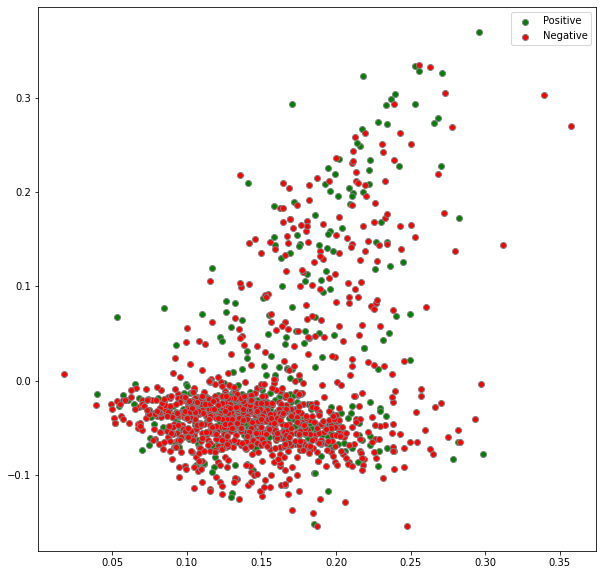

In [ ]:
  from sklearn.decomposition import PCA, TruncatedSVD

# Take all of the data and plot it on 2 dimensions
#pca = PCA(n_components=2)
  svd = TruncatedSVD(n_components=2)

#for k, v in datasetDict.items():
  #X = v['clean_text']
  X= mov_df['clean_text']
  encoder = LabelEncoder()
  #y = encoder.fit_transform(v['polarity'])
  y = encoder.fit_transform(mov_df['polarity'])
  print("--------------------------------------------------------------------------- Dataset:",k )
  print('Dataset: ', X.shape)

  vectorizer = TfidfVectorizer()
  X_vectorized = vectorizer.fit_transform(X)
  features_count = len(vectorizer.vocabulary_)
  print("-------------------------------------- Vecotizor: Tfidf")
  print('Number of features: ', features_count)
  print('Shape of training X: ', X_vectorized.shape)
  
  #pca.fit(X_vectorized)
  #pca_features = pca.transform(X_vectorized)
  svd.fit(X_vectorized)
  svd_features = svd.transform(X_vectorized)
  # plot of all the numbers
  #plot_PCA_2D(svd_features, target=y, target_names=v['polarity'].values)
  plot_PCA_2D(svd_features, target=y, target_names= (['Positive','Negative']))

In [ ]:
for k, v in datasetDict.items():
  name= k + "_preprocessed.csv"
  v.to_csv(name)

In [ ]:
from google.colab import files
for k, v in datasetDict.items():
  name= k + "_preprocessed.csv"
  files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>